In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import joblib


In [13]:
train_path=r"C:\Users\Asus\Desktop\Codeverse\Dataset\train.csv"
test_path=r"C:\Users\Asus\Desktop\Codeverse\Dataset\test.csv"
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
train_df.head()
test_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9
3,fffe3100370039003200,2008-02-07,Female,Service,No,3.0,6.0,4.6
4,fffe32003600390036003700,2008-07-17,Female,Product,No,2.0,5.0,6.4


In [14]:
df = train_df.copy()
df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])
df['Experience (Years)'] = (pd.to_datetime('today') - df['Date of Joining']).dt.days // 365
df.drop(columns=["Employee ID", "Date of Joining"], inplace=True)


In [15]:
df['Resource Allocation'].fillna(df['Resource Allocation'].median(), inplace=True)
df['Mental Fatigue Score'].fillna(df['Mental Fatigue Score'].median(), inplace=True)


C:\Users\Asus\AppData\Local\Temp\ipykernel_23300\2501829704.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Resource Allocation'].fillna(df['Resource Allocation'].median(), inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_23300\2501829704.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [17]:
for col in ['Gender', 'Company Type', 'WFH Setup Available']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df['Is New Joiner'] = df['Experience (Years)'] < 2
df['Work Mode Risk'] = df['WFH Setup Available'] * df['Company Type']  # encodes if WFH & Service
df['Fatigue × Resource'] = df['Mental Fatigue Score'] * df['Resource Allocation']

df = df.dropna(subset=['Burn Rate'])


df.head()


,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Experience (Years),Is New Joiner,Work Mode Risk,Fatigue × Resource
0,0,1,0,2.0,3.0,3.8,0.16,16,False,0,11.4
1,1,1,1,1.0,2.0,5.0,0.36,16,False,1,10.0
2,0,0,1,2.0,4.0,5.8,0.49,17,False,0,23.2
3,1,1,1,1.0,1.0,2.6,0.20,16,False,1,2.6
4,0,1,0,3.0,7.0,6.9,0.52,16,False,0,48.3


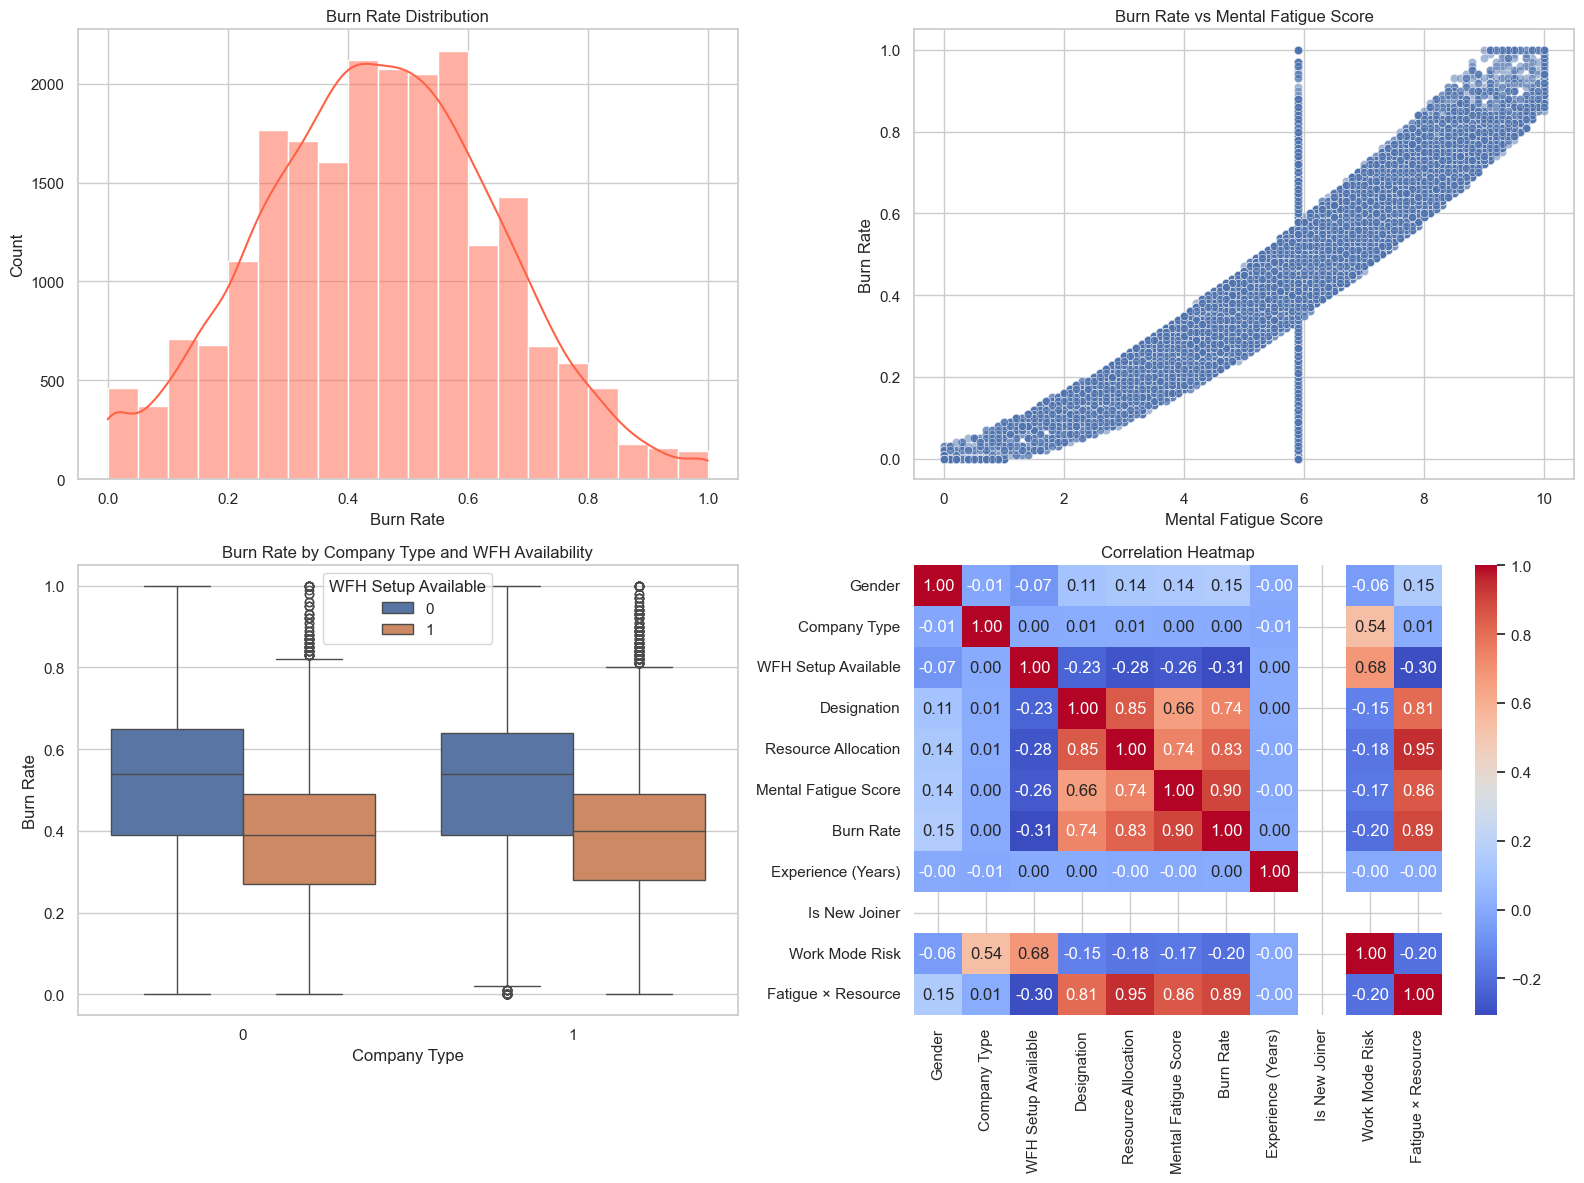

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.histplot(df['Burn Rate'], bins=20, kde=True, color='tomato')
plt.title('Burn Rate Distribution')

plt.subplot(2, 2, 2)
sns.scatterplot(x='Mental Fatigue Score', y='Burn Rate', data=df, alpha=0.5)
plt.title('Burn Rate vs Mental Fatigue Score')


plt.subplot(2, 2, 3)
sns.boxplot(x='Company Type', y='Burn Rate', hue='WFH Setup Available', data=df)
plt.title('Burn Rate by Company Type and WFH Availability')


plt.subplot(2, 2, 4)
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [23]:
X = df.drop(columns=["Burn Rate"])
y = df["Burn Rate"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    print(f"{name}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

Linear Regression: RMSE = 0.0703, R² = 0.8704
Random Forest: RMSE = 0.0657, R² = 0.8865
Gradient Boosting: RMSE = 0.0612, R² = 0.9018


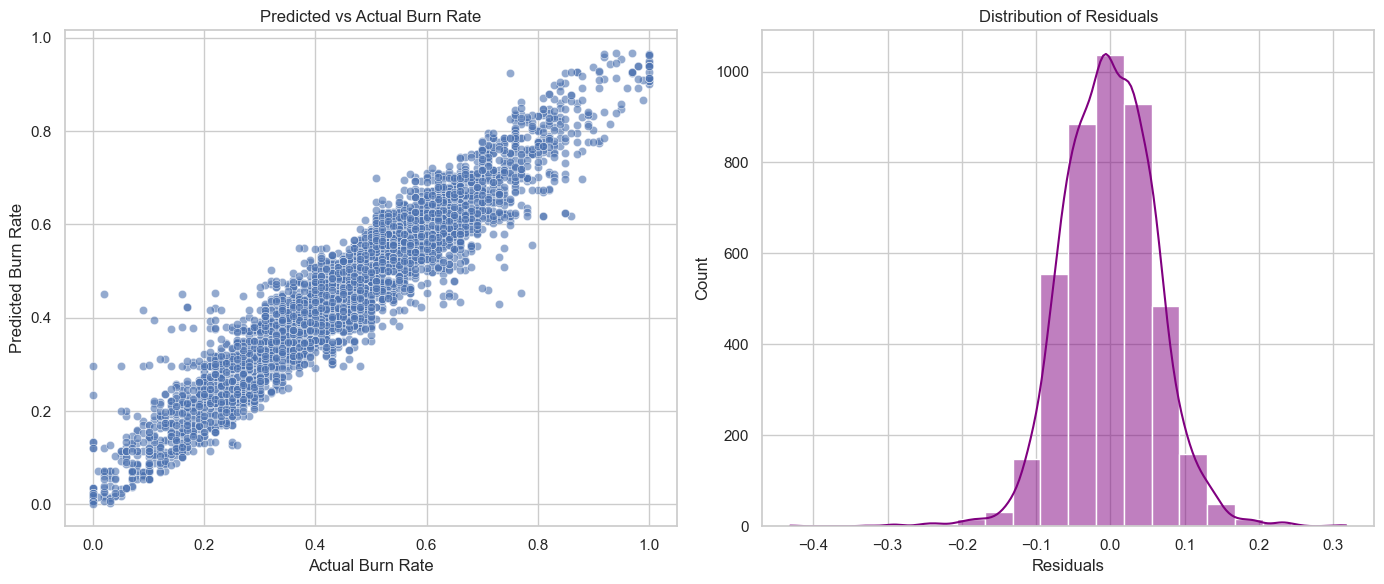

In [29]:
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_val)


residuals = y_val - preds

plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=preds, alpha=0.6)
plt.xlabel("Actual Burn Rate")
plt.ylabel("Predicted Burn Rate")
plt.title("Predicted vs Actual Burn Rate")


plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=20, kde=True, color='purple')
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")

plt.tight_layout()
plt.show()

In [31]:
joblib.dump(model, 'burnout_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']